**рекуррентная нейронная сеть Элмана**

Евгений Борисов <esborisov@sevsu.ru>

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [2]:
ex_count = 30 #  количество примеров
seq_len = 8  #  длинна последовательности
input_size = 11 # размер одного элемента последовательности
class_count = 2 #  количество классов
hl_size = 7 # размер скрытого слоя

In [3]:
X = np.random.rand(ex_count,input_size,seq_len) # последовательности
y = np.random.randint(0,class_count,ex_count) # номера классов

In [4]:
# X

In [5]:
y = OneHotEncoder(sparse=False,categories='auto').fit_transform(y.reshape(-1, 1))

In [6]:
X.shape, y.shape

((30, 11, 8), (30, 2))

In [7]:
net_size = [ input_size, hl_size, class_count ] # размеры слоёв сети
net_size

[11, 7, 2]

In [8]:
# инициализация весов

# матрица весов первого (скрытого) слоя 
W1  = np.random.normal(loc=0.0, scale=.1, size=(input_size,hl_size))
# матрица весов обратных связей скрытого слоя
W1r = np.random.normal(loc=0.0, scale=.1, size=(hl_size,hl_size))
# вектор сдвигов скрытого слоя
S1  = np.zeros(hl_size)

# матрица весов выходного слоя 
W2  = np.random.normal(loc=0.0, scale=.1, size=(hl_size,class_count))
# вектор сдвигов выходного слоя
S2  = np.zeros(class_count)

( 
W1.shape, 
W1r.shape, 
S1.shape,
W2.shape, 
S2.shape 
)


((11, 7), (7, 7), (7,), (7, 2), (2,))

---

In [9]:
# активация скрытого слоя
def act1(x): return np.tanh(x)
def act1_drv(x):return 1.0/(np.cosh(x)**2)

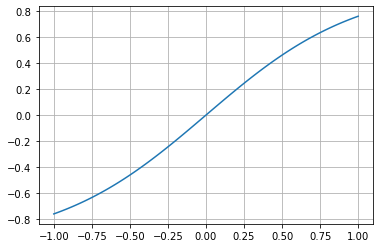

In [10]:
jj = np.linspace(-1.0,1.0,100)
plt.plot( jj, act1(jj) )
plt.grid()
plt.show()

---

In [11]:
# активация выходного слоя
def act2(x): 
    xe = np.exp(x)
    return xe/xe.sum(axis=1).reshape(-1,1)

def act2_drv(x): return 1.0 

---

In [12]:
# функция потери - средняя кросс-энтропия
def loss(o,y):
    o_restr = np.minimum(0.99999,np.maximum(1e-9,o))
    return -( y*np.log(o_restr) + (1-y)*np.log(1.0-o_restr) ).sum() / y.shape[0]    

In [13]:
def run(x,w1,w1r,s1,w2,s2):
    # начальное состояние скрытого слоя
    o = np.zeros( [ex_count, hl_size] )
    seq_len = x.shape[2] # длинна последовательностей
    for i in range(seq_len): o = act1( x[:,:,i].dot(w1) + o.dot(w1r) + s1 )
    return act2( o.dot(w2) + s2 )

In [14]:
def rnn_bptt_forward(x,w1,w1r,s1,w2,s2):
    seq_len = x.shape[2] # длинна последовательностей
    
    hs = [] # история состояний скрытого слоя
    ho = [] # история выходов скрытого слоя
    h = np.zeros( [ex_count, hl_size] ) # начальное состояние выхода скрытого слоя
    
    for i in range(seq_len): 
        h = x[:,:,i].dot(w1) + h.dot(w1r) + s1 
        hs.append(h)
        h = act1(h)
        ho.append(h)

    o = act2( h.dot(w2) + s2 )
    
    return hs,ho,o

In [15]:
def rnn_bptt_backward(w1r,w2,y,o,hs):
    seq_len = len(hs) # длинна последовательностей
    e2 = o - y # ошибка выходного слоя
    # ошибка скрытого слоя на последнем элементе входной последовательности
    e1 = [ e2.dot(w2.T) * act1_drv( hs[-1] ) ]
    # ошибка скрытого слоя на элементе входной последовательности номер t
    for t in range(seq_len-2,-1,-1): 
        e1.append( e1[-1].dot(w1r.T) * act1_drv( hs[t] ) )
     
    e1 = list(reversed( e1)) 
    
    return e2,e1

In [16]:
def rnn_bptt_gradient(x,w1,w1r,s1,w2,s2,e1,e2,ho):
    seq_len = len(hs) # длинна последовательностей

    dw2 = hs[-1].T.dot(e2)
    ds2 = e2.sum(axis=0)

    t=0
    xt = x[:,:,t]
    dw1 = xt.T.dot( e1[t] )
    dw1r = 0.0
    ds1 = e1[t].sum(axis=0)

    for t in range(1,seq_len):
        xt = X[:,:,t]
        dw1 += xt.T.dot( e1[t] )
        ds1 += e1[t].sum(axis=0)
        dw1r += ho[t].T.dot( e1[t] )

    return dw1,dw1r,ds1,dw2,ds2    


In [17]:
def weigth_norm(w1,w1r,s1,w2,s2):
    nn = np.linalg.norm(np.hstack([w1.flatten(),w1r.flatten(),s1,w2.flatten(),s2]))
    nn = nn if (nn!=0.0) else 1.0
    return (w1/nn,w1r/nn,s1/nn,w2/nn,s2/nn)

    #nn = np.abs( np.hstack([ v.flatten(), w.flatten() ]) ).max()


In [18]:
a=0.05
e_bound=1e-2

loss_hist=[]

for i in range(1000):
    o = run(X,W1,W1r,S1,W2,S2)
    loss_hist.append( loss(o,y) )
    if loss_hist[-1]<e_bound: break

    hs,ho,o = rnn_bptt_forward(X,W1,W1r,S1,W2,S2)
    e2,e1 = rnn_bptt_backward(W1r,W2,y,o,hs)
    dW1,dW1r,dS1,dW2,dS2 = rnn_bptt_gradient(X,W1,W1r,S1,W2,S2,e1,e2,ho)
    dW1,dW1r,dS1,dW2,dS2 = weigth_norm(dW1,dW1r,dS1,dW2,dS2 ) 

    W1,W1r,S1,W2,S2 = W1-a*dW1, W1r-a*dW1r, S1-a*dS1, W2-a*dW2, S2-a*dS2

In [19]:
i,loss_hist[-1]

(226, 0.009720846121883727)

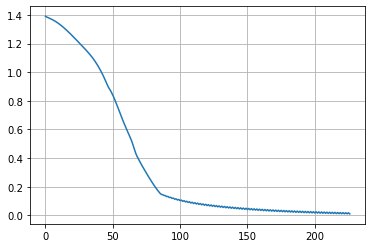

In [20]:
plt.plot( loss_hist )
plt.grid()
plt.show()